In [5]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import calendar

In [698]:
import warnings 
warnings.filterwarnings("ignore")

Loading Datasets

In [699]:
x_train=pd.read_csv(r"F:\Edureka\PGP AI_ML\MID TERM PROJECT-1\Dataset\train.csv")
y_train=pd.read_csv(r"F:\Edureka\PGP AI_ML\MID TERM PROJECT-1\Dataset\train_label.csv",header=None)
y_train.columns=["total_bookings"]

x_test=pd.read_csv(r"F:\Edureka\PGP AI_ML\MID TERM PROJECT-1\Dataset\test.csv")
y_test=pd.read_csv(r"F:\Edureka\PGP AI_ML\MID TERM PROJECT-1\Dataset\test_label.csv",header=None)
y_test.columns=["total_bookings"]

x_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000
4,6/2/2012 12:00,Summer,0,0,Clear + Few clouds,25.42,31.060,43,23.9994


In [700]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((8708, 9), (8708, 1), (2178, 9), (2178, 1))

In [701]:
x_train.dtypes

datetime       object
season         object
holiday         int64
workingday      int64
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

# TASK 2- QUESTION 1- FEATURE ENGINEERING

Creating date, hour, weekday, month and removing datetime, for better understanding of the dataset

In [702]:
x_train['date']=x_train.datetime.apply(lambda x : x.split()[0])
x_train['hour']=x_train.datetime.apply(lambda x : x.split()[1].split(":")[0])
x_train["weekday"]=x_train.date.apply(lambda x : calendar.day_name[datetime.strptime(x,"%m/%d/%Y").weekday()])
x_train["month"]=x_train.date.apply(lambda x : calendar.month_name[datetime.strptime(x,"%m/%d/%Y").month])
x_train.drop(["datetime"],axis=1,inplace=True)

#same changes for x_test as well

x_test['date']=x_test.datetime.apply(lambda x : x.split()[0])
x_test['hour']=x_test.datetime.apply(lambda x : x.split()[1].split(":")[0])
x_test["weekday"]=x_test.date.apply(lambda x : calendar.day_name[datetime.strptime(x,"%m/%d/%Y").weekday()])
x_test["month"]=x_test.date.apply(lambda x : calendar.month_name[datetime.strptime(x,"%m/%d/%Y").month])
x_test.drop(["datetime"],axis=1,inplace=True)

In [703]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,9/5/2012,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,1/13/2011,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,11/18/2011,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,9/13/2011,13,Tuesday,September


In [704]:
x_train.dtypes

season         object
holiday         int64
workingday      int64
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
date           object
hour           object
weekday        object
month          object
dtype: object

In [705]:
x_train["weather"].unique()

array([' Clear + Few clouds', ' Light Snow, Light Rain',
       ' Mist + Cloudy ', ' Heavy Rain + Thunderstorm '], dtype=object)

Here, we can notice that, if it is-

1. clear, for sure the other half is few clouds
2. light snow, for sure the other half is light rain
3. mist, for sure the other half is cloudy
4. heavy rain, for sure the other half is thunderstorm.

Hence, we dont need to consider the second half, and we can keep only the first half

In [706]:
x_train["weather"]=x_train.weather.apply(lambda x : x.split(" + ")[0])
x_train["weather"]=x_train.weather.apply(lambda x : x.replace("Light Snow, Light Rain","Light Snow"))

#applying the same changes on test data

x_test["weather"]=x_test.weather.apply(lambda x : x.split(" + ")[0])
x_test["weather"]=x_test.weather.apply(lambda x : x.replace("Light Snow, Light Rain","Light Snow"))

x_train.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month
0,Summer,0,1,Clear,22.14,25.760,77,16.9979,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear,28.70,33.335,79,19.0012,9/5/2012,4,Wednesday,September
2,Spring,0,1,Clear,5.74,6.060,50,22.0028,1/13/2011,9,Thursday,January
3,Winter,0,1,Clear,13.94,16.665,29,8.9981,11/18/2011,16,Friday,November
4,Fall,0,1,Clear,30.34,33.335,51,19.0012,9/13/2011,13,Tuesday,September
5,Fall,0,1,Clear,33.62,12.120,36,22.0028,8/17/2012,17,Friday,August
6,Winter,0,0,Clear,24.60,29.545,73,12.9980,10/6/2012,9,Saturday,October
7,Fall,0,1,Clear,21.32,25.000,68,19.0012,9/10/2012,4,Monday,September
8,Fall,0,0,Light Snow,27.06,31.060,61,7.0015,7/14/2012,4,Saturday,July
9,Spring,0,0,Clear,12.30,15.150,56,11.0014,2/6/2011,18,Sunday,February


# TASK 1- QUESTION 1- DATA VISUALIZATION

combining x_train and y_train to ease visualizations

In [707]:
x=x_train
x["total_bookings"]=y_train
x.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,total_bookings
0,Summer,0,1,Clear,22.14,25.760,77,16.9979,5/2/2012,19,Wednesday,May,504
1,Fall,0,1,Clear,28.70,33.335,79,19.0012,9/5/2012,4,Wednesday,September,5
2,Spring,0,1,Clear,5.74,6.060,50,22.0028,1/13/2011,9,Thursday,January,139
3,Winter,0,1,Clear,13.94,16.665,29,8.9981,11/18/2011,16,Friday,November,209
4,Fall,0,1,Clear,30.34,33.335,51,19.0012,9/13/2011,13,Tuesday,September,184


season vs total bookings, to see how the bookings are related with the kind of season

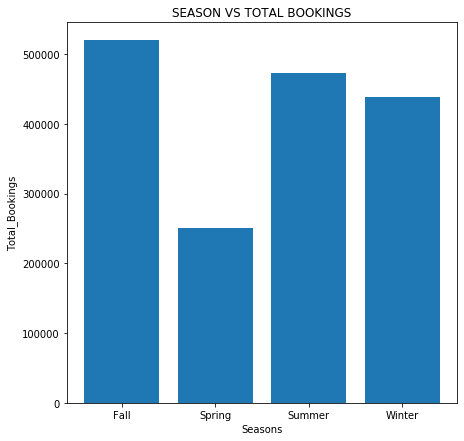

In [708]:
bookings_season=x.groupby(["season"])
season=list(bookings_season["season"].first())
bookings_season=list(bookings_season["total_bookings"].sum())

plt.figure(figsize=(7,7))
y_pos=np.arange(len(season))
plt.bar(y_pos,bookings_season,align="center")
plt.xticks(y_pos,season)
plt.xlabel("Seasons")
plt.ylabel("Total_Bookings")
plt.title("SEASON VS TOTAL BOOKINGS")
plt.show()

we can infer that spring season recieved the least number of bookings, and fall recieved the highest number of bookings




temp vs total bookings, to see how the bookings are related with temp

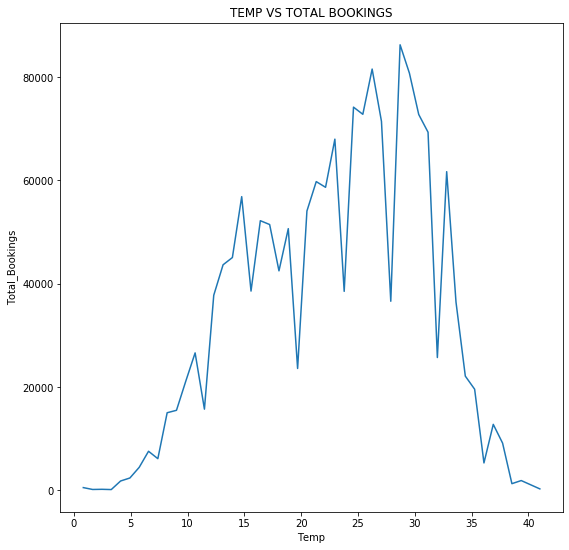

In [709]:
bookings_temp=x.groupby(["temp"]).sum().reset_index()
bookings_temp=bookings_temp.sort_values(by=["temp"])
temp=list(bookings_temp["temp"])
bookings_temp=list(bookings_temp["total_bookings"])

plt.figure(figsize=(9,9))
plt.plot(temp,bookings_temp)
plt.xlabel("Temp")
plt.ylabel("Total_Bookings")
plt.title("TEMP VS TOTAL BOOKINGS")
plt.show()

we can infer that when temp is between 25 and 30, we are getting highest number of bookings, and if the temp is less than 5 or greater than 40, we are having the least number of bookings




weekday vs total bookings, to see how the bookings are related with weekday

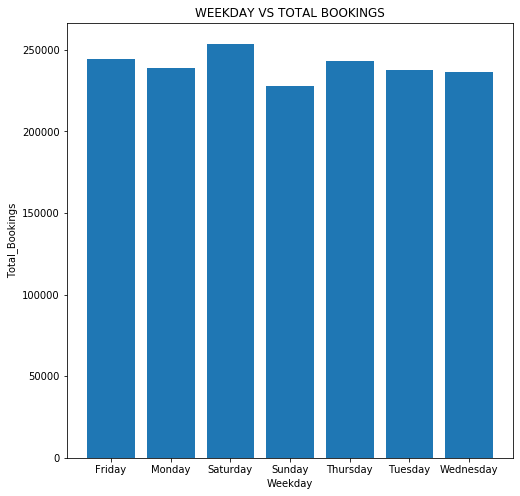

In [710]:
bookings_weekday=x.groupby(["weekday"])
weekday=list(bookings_weekday["weekday"].first())
bookings_weekday=list(bookings_weekday["total_bookings"].sum())

plt.figure(figsize=(8,8))
y_pos=np.arange(len(weekday))
plt.bar(y_pos,bookings_weekday,align="center")
plt.xticks(y_pos,weekday)
plt.xlabel("Weekday")
plt.ylabel("Total_Bookings")
plt.title("WEEKDAY VS TOTAL BOOKINGS")
plt.show()

we can infer that total bookings are almost same every day, but saturday witnessed slightly higher number of bookings and sunday recieved slightly less number of bookings





weather vs total bookings, to see how the bookings are related with weekday

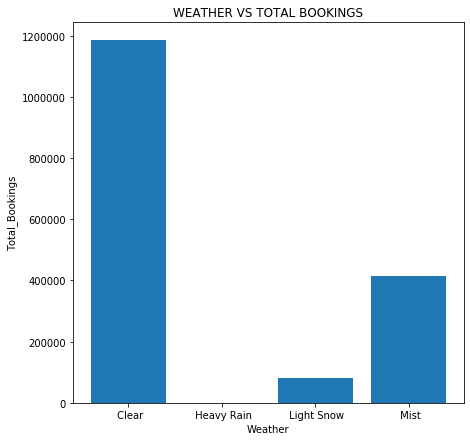

In [711]:
bookings_weather=x.groupby(["weather"])
weather=list(bookings_weather["weather"].first())
bookings_weather=list(bookings_weather["total_bookings"].sum())

plt.figure(figsize=(7,7))
y_pos=np.arange(len(weather))
plt.bar(y_pos,bookings_weather,align="center")
plt.xticks(y_pos,weather)
plt.xlabel("Weather")
plt.ylabel("Total_Bookings")
plt.title("WEATHER VS TOTAL BOOKINGS")
plt.show()

we can infer that when the weather is clear, there are huge number of bookings. but if there is light snow or heavy rain, there are very less number of bookings. and if the weather is mist, there are fair number of bookings.



hour vs total bookings, to see what hour is the peak time 

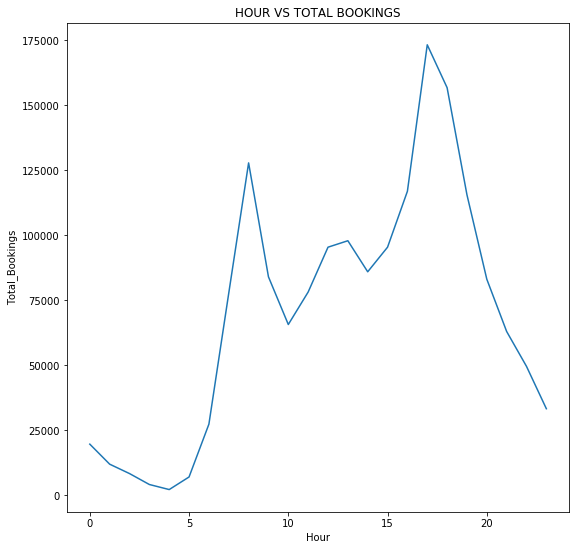

In [712]:
bookings_hour=x.groupby(["hour"]).sum().reset_index()
bookings_hour["hour"]=bookings_hour.hour.apply(lambda x : int(x))
bookings_hour=bookings_hour.sort_values(by=["hour"])
hour=list(bookings_hour["hour"])
bookings_hour=list(bookings_hour["total_bookings"])

plt.figure(figsize=(9,9))
plt.plot(hour,bookings_hour)
plt.xlabel("Hour")
plt.ylabel("Total_Bookings")
plt.title("HOUR VS TOTAL BOOKINGS")
plt.show()

we can infer that between 3 and 8 in the evening there is a hike in the total number of bookings, and around 4 in the morning there are very less number of bookings. 



month vs total booking, to see trend of bookings in different months

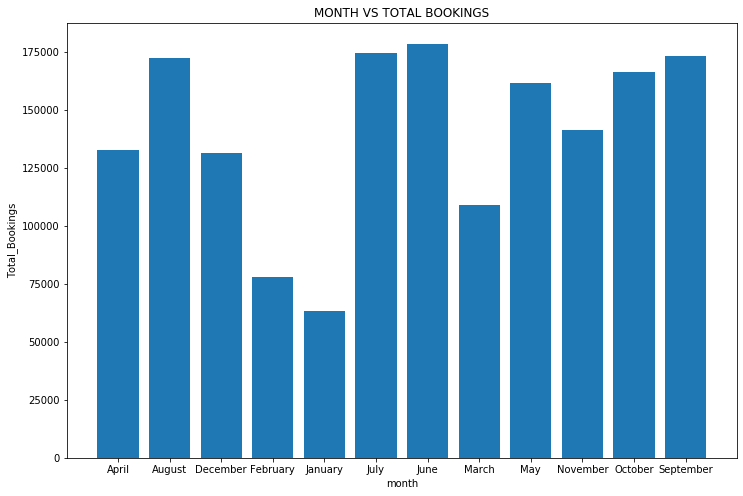

In [713]:
bookings_month=x.groupby(["month"]).sum().reset_index()
month=list(bookings_month["month"])
bookings_month=list(bookings_month["total_bookings"])

plt.figure(figsize=(12,8))
y_pos=np.arange(len(month))
plt.bar(y_pos,bookings_month,align="center")
plt.xticks(y_pos,month)
plt.xlabel("month")
plt.ylabel("Total_Bookings")
plt.title("MONTH VS TOTAL BOOKINGS")
plt.show()

we can infer that january recieves the lowest bookings, whereas june recieves the highest bookings(july, august, september are also recieving high bookings).

# TASK 1- QUESTION 2- OUTLIER ANALYSIS

there are 4 columns having continous data, and hence we check for the outliers on those columns using boxplot

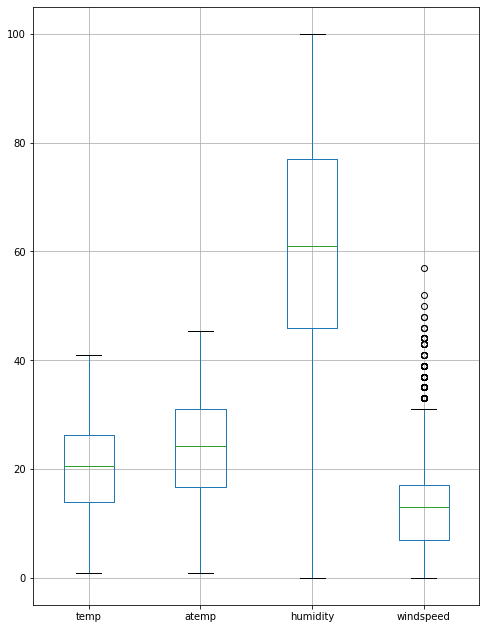

In [714]:
plt.figure(figsize=(8,11))
x.boxplot(column=["temp","atemp","humidity","windspeed"])

we can see there are no outliers in columns temp, atemp. but there are outliers in windspeed column and humidity column

In [715]:
#outlier removal from windspeed column
q1=x["windspeed"].quantile(0.25)
q3=x["windspeed"].quantile(0.75)
iqr=q3-q1
x=x[((x[["windspeed"]]>=q1-1.5*iqr) & (x[["windspeed"]]<=q3+1.5*iqr)).all(axis=1)]
print(x.shape)

#outlier removal from humidity column
q1=x["humidity"].quantile(0.25)
q3=x["humidity"].quantile(0.75)
iqr=q3-q1
x=x[((x[["humidity"]]>=q1-1.5*iqr) & (x[["humidity"]]<=q3+1.5*iqr)).all(axis=1)]
print(x.shape)

(8526, 13)
(8509, 13)


verifying that there are no outliers after removal.

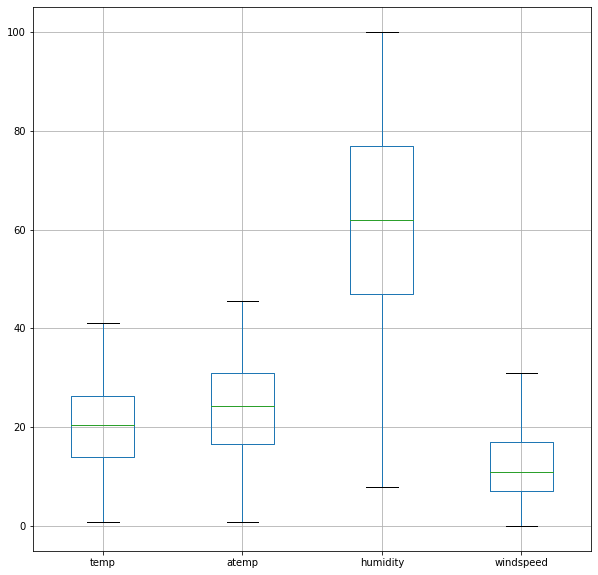

In [716]:
plt.figure(figsize=(10,10))
x.boxplot(column=["temp","atemp","humidity","windspeed"])

there are no outliers in our dataset now.

# TASK 1- QUESTION 3- MISSING VALUE ANALYSIS

In [717]:
x.isnull().sum()

season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
date              0
hour              0
weekday           0
month             0
total_bookings    0
dtype: int64

there are no missing values in our dataset.

# TASK 2- QUESTION 1- FEATURE ENGINEERING

TREATMENT OF HOLIDAY AND WORKING DAY COLUMNS IN TRAINING DATASET. THE SAME PROCESS IS DONE ON TEST DATASET AFTER SOME BLOCKS OF CODE

In [718]:
(x["workingday"]==x["holiday"]).sum()

2483

holiday and working day column values are always complement of each other. but there are 2483 rows where holiday and working day column values are equal. hence these needs to be cleansed. dropping 2483 rows is equal to dropping 30% of total rows, which is not a good thing to do.

extracting the dataset which is having correct values with number of rows 8509-2483=6026

In [719]:
#datset in which entries are correctly recorded, i.e, where workingday+holiday==1
correct=x[x["workingday"]!=x["holiday"]]
correct.shape

(6026, 13)

In [720]:
#dataset in which entries are wrongly recorded, i.e, where workingday+holiday!=1
wrong=x[x["workingday"]==x["holiday"]]
wrong.shape

(2483, 13)

In [721]:
#preparing to pass through the ml algorithm
x_correct=correct[["total_bookings"]]
y1_correct=correct[["workingday"]]
y2_correct=correct[["holiday"]]

x_wrong=wrong[["total_bookings"]]

In [722]:
#getting the predicted values of working day
lr=LogisticRegression()
lr.fit(x_correct,y1_correct)
y1_wrong_pred1=lr.predict(x_wrong)

#getting the predicted values of holiday
lr=LogisticRegression()
lr.fit(x_correct,y2_correct)
y2_wrong_pred1=lr.predict(x_wrong)

#checking if there are any rows in which workingday+holiday!=1
wrong_rows=(y1_wrong_pred1==y2_wrong_pred1).sum()
wrong_rows

0

In [723]:
wrong["workingday"]=y1_wrong_pred1
wrong["holiday"]=y2_wrong_pred1

In [724]:
#joining back correct and wrong, to get the combined 'x'
x=pd.concat([correct,wrong])
x.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,total_bookings
0,Summer,0,1,Clear,22.14,25.760,77,16.9979,5/2/2012,19,Wednesday,May,504
1,Fall,0,1,Clear,28.70,33.335,79,19.0012,9/5/2012,4,Wednesday,September,5
2,Spring,0,1,Clear,5.74,6.060,50,22.0028,1/13/2011,9,Thursday,January,139
3,Winter,0,1,Clear,13.94,16.665,29,8.9981,11/18/2011,16,Friday,November,209
4,Fall,0,1,Clear,30.34,33.335,51,19.0012,9/13/2011,13,Tuesday,September,184


here we get back our 'x', having 8509 rows again, but with working day and holiday issue resolved

In [725]:
#since, working day and holiday implies each other, we can drop any one of these 2
x.drop(columns=["holiday","date"],axis=1,inplace=True)
x.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,total_bookings
0,Summer,1,Clear,22.14,25.760,77,16.9979,19,Wednesday,May,504
1,Fall,1,Clear,28.70,33.335,79,19.0012,4,Wednesday,September,5
2,Spring,1,Clear,5.74,6.060,50,22.0028,9,Thursday,January,139
3,Winter,1,Clear,13.94,16.665,29,8.9981,16,Friday,November,209
4,Fall,1,Clear,30.34,33.335,51,19.0012,13,Tuesday,September,184


# TASK 1- QUESTION 4- DATA VISUALIZATION

season vs total bookings, to see how the bookings are related with the kind of season

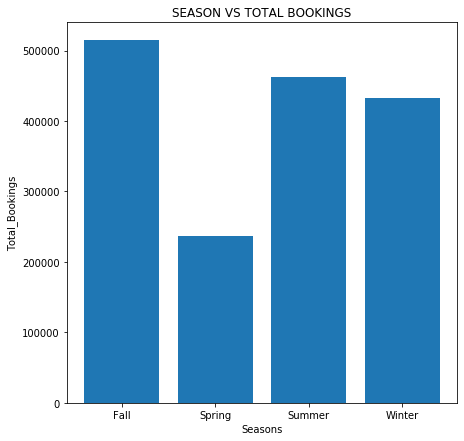

In [726]:
bookings_season=x.groupby(["season"])
season=list(bookings_season["season"].first())
bookings_season=list(bookings_season["total_bookings"].sum())

plt.figure(figsize=(7,7))
y_pos=np.arange(len(season))
plt.bar(y_pos,bookings_season,align="center")
plt.xticks(y_pos,season)
plt.xlabel("Seasons")
plt.ylabel("Total_Bookings")
plt.title("SEASON VS TOTAL BOOKINGS")
plt.show()

we can infer that spring season recieved the least number of bookings, and fall recieved the highest number of bookings






temp vs total bookings, to see how the bookings are related with temp

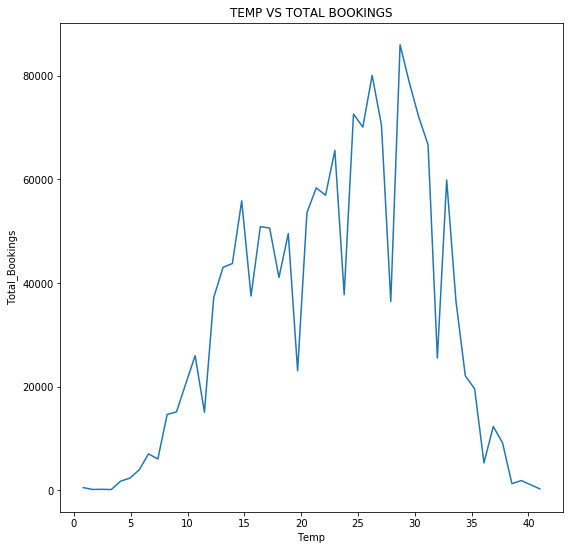

In [727]:
bookings_temp=x.groupby(["temp"]).sum().reset_index()
bookings_temp=bookings_temp.sort_values(by=["temp"])
temp=list(bookings_temp["temp"])
bookings_temp=list(bookings_temp["total_bookings"])

plt.figure(figsize=(9,9))
plt.plot(temp,bookings_temp)
plt.xlabel("Temp")
plt.ylabel("Total_Bookings")
plt.title("TEMP VS TOTAL BOOKINGS")
plt.show()

we can infer that when temp is between 25 and 30, we are getting highest number of bookings, and if the temp is less than 5 or greater than 40, we are having the least number of booings






weekday vs total bookings, to see how the bookings are related with weekday

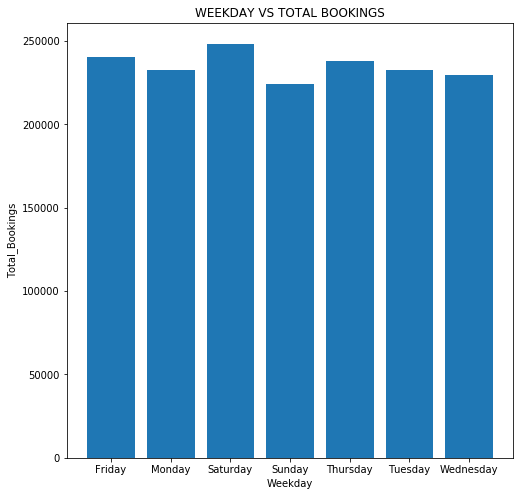

In [728]:
bookings_weekday=x.groupby(["weekday"])
weekday=list(bookings_weekday["weekday"].first())
bookings_weekday=list(bookings_weekday["total_bookings"].sum())

plt.figure(figsize=(8,8))
y_pos=np.arange(len(weekday))
plt.bar(y_pos,bookings_weekday,align="center")
plt.xticks(y_pos,weekday)
plt.xlabel("Weekday")
plt.ylabel("Total_Bookings")
plt.title("WEEKDAY VS TOTAL BOOKINGS")
plt.show()

we can infer that total bookings are almost same every day, but saturday witnessed slightly higher number of bookings and sunday recieved slightly less number of bookings





weather vs total bookings, to see how the bookings are related with weekday

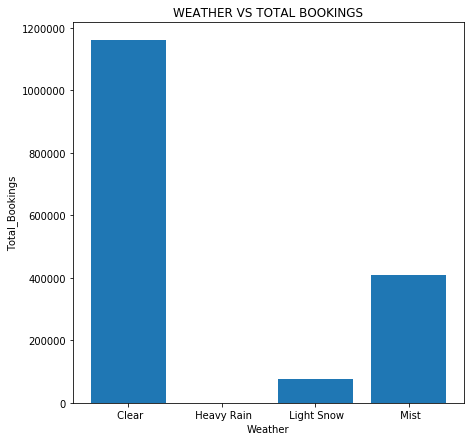

In [729]:
bookings_weather=x.groupby(["weather"])
weather=list(bookings_weather["weather"].first())
bookings_weather=list(bookings_weather["total_bookings"].sum())

plt.figure(figsize=(7,7))
y_pos=np.arange(len(weather))
plt.bar(y_pos,bookings_weather,align="center")
plt.xticks(y_pos,weather)
plt.xlabel("Weather")
plt.ylabel("Total_Bookings")
plt.title("WEATHER VS TOTAL BOOKINGS")
plt.show()

we can infer that when the weather is clear, there are huge number of bookings. but if there is light snow or heavy rain, there are very less number of bookings. and if the weather is mist, there are fair number of bookings.



hour vs total bookings, to see what hour is the peak time 

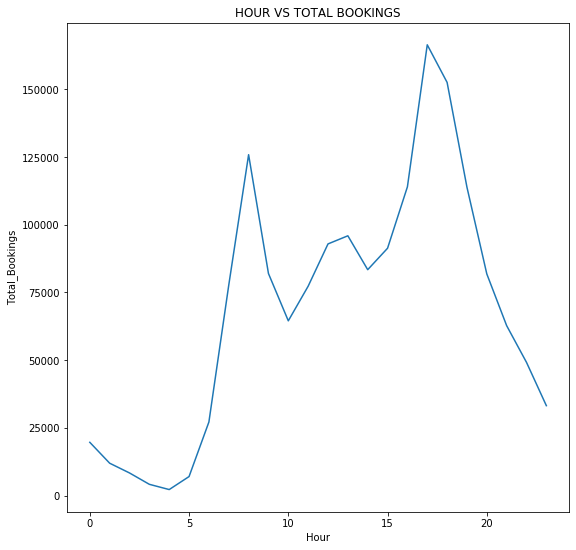

In [730]:
bookings_hour=x.groupby(["hour"]).sum().reset_index()
bookings_hour["hour"]=bookings_hour.hour.apply(lambda x : int(x))
bookings_hour=bookings_hour.sort_values(by=["hour"])
hour=list(bookings_hour["hour"])
bookings_hour=list(bookings_hour["total_bookings"])

plt.figure(figsize=(9,9))
plt.plot(hour,bookings_hour)
plt.xlabel("Hour")
plt.ylabel("Total_Bookings")
plt.title("HOUR VS TOTAL BOOKINGS")
plt.show()

we can infer that between 3 and 6 in the evening there is a hike in the total number of bookings, and between 2 and 6 in the morning there are very less number of bookings. minimum bookings are between 4-5 in the morning, and maximum bookings are between 4-6 in the morning.



month vs total booking, to see trend of bookings in different months

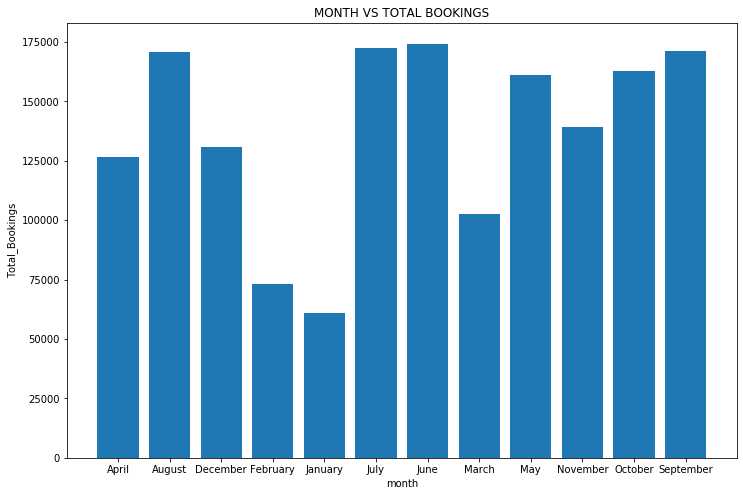

In [731]:
bookings_month=x.groupby(["month"]).sum().reset_index()
month=list(bookings_month["month"])
bookings_month=list(bookings_month["total_bookings"])

plt.figure(figsize=(12,8))
y_pos=np.arange(len(month))
plt.bar(y_pos,bookings_month,align="center")
plt.xticks(y_pos,month)
plt.xlabel("month")
plt.ylabel("Total_Bookings")
plt.title("MONTH VS TOTAL BOOKINGS")
plt.show()

we can infer that january recieves the lowest bookings, whereas june recieves the highest bookings(july, august, september are also recieving high bookings).

# TASK 2- QUESTION 1- FEATURE ENGINEERING

In [732]:
#label encoding columns with categorical values
cat_columns=["season","weather","weekday","month","hour"]
le=LabelEncoder()
for column in cat_columns:
    x[column]=le.fit_transform(x[column])
x.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,total_bookings
0,2,1,0,22.14,25.760,77,16.9979,11,6,8,504
1,0,1,0,28.70,33.335,79,19.0012,18,6,11,5
2,1,1,0,5.74,6.060,50,22.0028,23,4,4,139
3,3,1,0,13.94,16.665,29,8.9981,8,0,9,209
4,0,1,0,30.34,33.335,51,19.0012,5,5,11,184


# TASK 1- QUESTION 5- CORRELATION ANALYSIS

(11.0, 0.0)

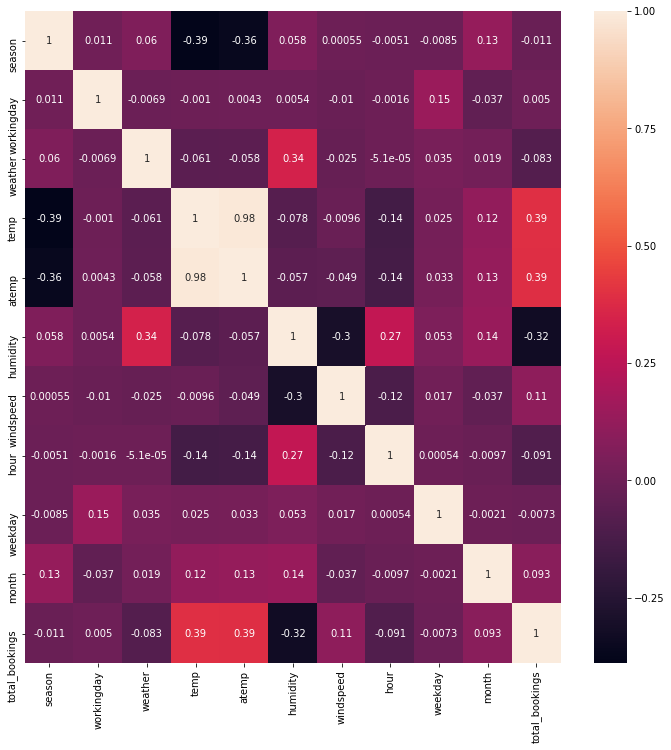

In [733]:
#heatmap to find the correlation between columns
corr=x.corr()
plt.figure(figsize=(12,12))
ax=sns.heatmap(corr,annot=True)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)

we can see that temp and atemp are having a correlation of 0.98, and total_Bookings have equal correlation with the two. hence we can drop any of these two, and total_bookings is having high correlation with temp, humidity.

In [734]:
x.drop(columns=["atemp"],axis=1,inplace=True)
x.head()

,season,workingday,weather,temp,humidity,windspeed,hour,weekday,month,total_bookings
0,2,1,0,22.14,77,16.9979,11,6,8,504
1,0,1,0,28.70,79,19.0012,18,6,11,5
2,1,1,0,5.74,50,22.0028,23,4,4,139
3,3,1,0,13.94,29,8.9981,8,0,9,209
4,0,1,0,30.34,51,19.0012,5,5,11,184


# TASK 2- QUESTION 1- FEATURE ENGINEERING

In [735]:
#standardisation
y_train=x[["total_bookings"]]
df=x.iloc[:,0:-1]
scaler=StandardScaler()
scaler.fit(df)
df=pd.DataFrame(scaler.transform(df))
df.columns=["season","workingday","weather","temp","humidity","windspeed","hour","weekday","month"]
x_train=df

Treatment of working day and holiday on test dataset

In [736]:
y=x_test
y["total_bookings"]=y_test
(y["workingday"]==y["holiday"]).sum()

627

holiday and working day column values are always complement of each other. but there are 627 rows where holiday and working day column values are equal. hence these needs to be cleansed. dropping 627 rows is equal to dropping 29% of total rows, which is not a good thing to do.

extracting the dataset which is having correct values with number of rows 2178-627=1551

In [737]:
#datset in which entries are correctly recorded, i.e, where workingday+holiday==1
correct=y[y["workingday"]!=y["holiday"]]
correct.shape

(1551, 13)

In [738]:
#dataset in which entries are wrongly recorded, i.e, where workingday+holiday!=1
wrong=y[y["workingday"]==y["holiday"]]
wrong.shape

(627, 13)

In [739]:
#preparing to pass through the ml algorithm
y_correct=correct[["total_bookings"]]
y1_correct=correct[["workingday"]]
y2_correct=correct[["holiday"]]

y_wrong=wrong[["total_bookings"]]

In [740]:
#getting the predicted values of working day
lr=LogisticRegression()
lr.fit(y_correct,y1_correct)
y1_wrong_pred1=lr.predict(y_wrong)

#getting the predicted values of holiday
lr=LogisticRegression()
lr.fit(y_correct,y2_correct)
y2_wrong_pred1=lr.predict(y_wrong)

#checking if there are any rows in which workingday+holiday!=1
wrong_rows=(y1_wrong_pred1==y2_wrong_pred1).sum()
wrong_rows

0

In [741]:
wrong["workingday"]=y1_wrong_pred1
wrong["holiday"]=y2_wrong_pred1

In [742]:
#joining back correct and wrong, to get the combined 'x'
y=pd.concat([correct,wrong])
y.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,total_bookings
0,Summer,0,1,Clear,21.32,25.000,48,35.0008,5/10/2012,11,Thursday,May,256
3,Winter,0,1,Mist,25.42,28.790,83,0.0000,10/13/2011,11,Thursday,October,84
5,Summer,0,1,Clear,12.30,15.910,61,6.0032,4/1/2011,23,Friday,April,53
7,Winter,0,1,Mist,16.40,20.455,50,11.0014,11/1/2012,18,Thursday,November,678
8,Winter,0,1,Clear,18.86,22.725,41,23.9994,10/12/2012,16,Friday,October,520


In [743]:
y.drop(columns=["holiday","date","atemp"],axis=1,inplace=True)
y.head()

,season,workingday,weather,temp,humidity,windspeed,hour,weekday,month,total_bookings
0,Summer,1,Clear,21.32,48,35.0008,11,Thursday,May,256
3,Winter,1,Mist,25.42,83,0.0000,11,Thursday,October,84
5,Summer,1,Clear,12.30,61,6.0032,23,Friday,April,53
7,Winter,1,Mist,16.40,50,11.0014,18,Thursday,November,678
8,Winter,1,Clear,18.86,41,23.9994,16,Friday,October,520


In [744]:
#label encoding the categorical columns
cat_columns=["season","weather","weekday","month","hour"]
le=LabelEncoder()
for column in cat_columns:
    y[column]=le.fit_transform(y[column])
y.head()

,season,workingday,weather,temp,humidity,windspeed,hour,weekday,month,total_bookings
0,2,1,0,21.32,48,35.0008,3,4,8,256
3,3,1,2,25.42,83,0.0000,3,4,10,84
5,2,1,0,12.30,61,6.0032,16,0,0,53
7,3,1,2,16.40,50,11.0014,10,4,9,678
8,3,1,0,18.86,41,23.9994,8,0,10,520


In [745]:
#standardisation
y_test=y[["total_bookings"]]
df=y.iloc[:,0:-1]
scaler=StandardScaler()
scaler.fit(df)
df=pd.DataFrame(scaler.transform(df))
df.columns=["season","workingday","weather","temp","humidity","windspeed","hour","weekday","month"]
x_test=df

# TASK 2- QUESTION 3- RERESSION ANALYSIS

In [746]:
#Final x_train,y_train,x_test,y_test
x_train=x_train[["temp","humidity","hour","weekday","windspeed","month","weather"]]
x_test=x_test[["temp","humidity","hour","weekday","windspeed","month","weather"]]

In [747]:
models=[DecisionTreeRegressor(),Lasso(),Ridge(),LinearRegression(),SVR()]
names=["DecisionTreeRegressor","Lasso","Ridge","LinearRegression","SVR"]
for model,name in zip(models,names):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    mse=mean_squared_error(y_test,y_pred)
    print(name,np.sqrt(mse))

DecisionTreeRegressor 93.89693077420277
Lasso 153.7715894288228
Ridge 153.73210895951107
LinearRegression 153.73202601872197
SVR 153.78813343301096


We can discard all the models and consider only DecisionTreeRegressor

# TASK 2- QUESTION 4- ENSEMBLE ANALYSIS

In [748]:
models=[xgb.XGBRegressor(),RandomForestRegressor(),AdaBoostRegressor()]
names=["Xgboost","RandomForest","AdaBoost"]
for model,name in zip(models,names):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    mse=mean_squared_error(y_test,y_pred)
    print(name,np.sqrt(mse))

Xgboost 62.375004894965834
RandomForest 71.56935410477733
AdaBoost 132.21268122328078


We can discard adaboost, random forest, and consider only xgboost

# TASK 2- QUESTION 2- GRID SEARCH FOR DECISION TREE

In [749]:
dtr=DecisionTreeRegressor()
pprint(dtr.get_params())

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


In [750]:
num_leafs = [1, 5, 10, 20, 40, 80]
max_depths = np.arange(1, 21)
parameters = {'max_depth':max_depths,'min_samples_leaf':num_leafs}
dtr_grid = GridSearchCV(dtr,parameters,cv = 2,n_jobs = -1,verbose=False)
dtr_grid.fit(x_train,y_train)
print("best parameters:",dtr_grid.best_params_)
model = dtr_grid.best_estimator_
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
print("rmse:",np.sqrt(mse))

best parameters: {'max_depth': 12, 'min_samples_leaf': 20}
rmse: 78.97175553995616


# TASK 2- QUESTION 2- GRID SEARCH FOR XGBOOST 

In [751]:
xgb = XGBRegressor(nthread=-1)
pprint(xgb.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'nthread': -1,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [752]:
parameters = {'min_child_weight':[2,3,4], 'gamma':[i/10.0 for i in range(4,15)], 'max_depth': [3,4,6],'random_state':[0,10,20], 'learning_rate':[0.1,0.01,None]}
xgb_grid = GridSearchCV(xgb,parameters,cv = 2,n_jobs = -1,verbose=False)
xgb_grid.fit(x_train,y_train)
print("best parameters:",xgb_grid.best_params_)
model = xgb_grid.best_estimator_
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
print("rmse:",np.sqrt(mse))

best parameters: {'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'random_state': 0}
rmse: 64.66490881339585


# FINAL MODELS

In [753]:
model=DecisionTreeRegressor(max_depth=10,min_samples_leaf=20)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
print("DecisionTree:",np.sqrt(mse))

DecisionTree: 78.6011067038566


In [754]:
import xgboost as xgb
model=xgb.XGBRegressor(gamma=0.4)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
print("xgboost:",np.sqrt(mse))

xgboost: 62.00334621644818


# RESULT

1. After all the analysis, we can see that xgboost which is an ensemble model is best in this problem. 
2. The work which is done on working day and holiday columns is not much useful, because finally i didnt consider them in predicting. 
3. We could also see that, the number of bookings are more dependent on temperature than that of the rest of columns, but i had an instinct that working day would be the most important column, and surprisingly  i didnt even consider it. So, its a lesson that we should never completely go on instincts, and everything depends on data.
4. we could see that, xgboost is working good with its default parameters, except gamma.